In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.special
import math

In [2]:
class NeuralNetwork:
    def __init__(self, input_nodes, hidden_nodes, hidden_layers, 
                 output_nodes,  learning_rate):
        self.inodes = input_nodes
        self.hnodes = hidden_nodes
        self.onodes = output_nodes
        self.lr = learning_rate
        self.node_params = [input_nodes]
        
        for i in range(hidden_layers):
            self.node_params.append(hidden_nodes)
            
        self.node_params.append(output_nodes)
                
        self.transition_count = hidden_layers + 1
        self.weights = []
        self.biases = []
        for i in range(self.transition_count):
            row, column = self.node_params[i + 1], self.node_params[i]
            self.weights.append(
                np.random.normal(0.0, pow(column, -0.5), (row, column))
            ) 
            self.biases.append(
                np.random.normal(
                    0.0, 0.0 + pow(self.hnodes, -0.5),
                    (row, 1))
            )
        self.activation_func = lambda x:scipy.special.expit(x.astype('float'))   
        self.epochs = []
        self.efficiency = []
        self.efficiency_on_train = []
        self.outputs = [None] * (self.transition_count + 1)
        self.errors = [None] * (self.transition_count + 1)
        
        
        
    def train_one_data_set(self, inputs_list, targets_list ):
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin=2).T
       
        remarks = []
        biases = []
        
        self.outputs[0] = inputs # zero (pseudo) outputs is an input in NN
        for i in range(self.transition_count):
            self.outputs[i + 1] = self.activation_func(
                np.dot(self.weights[i], self.outputs[i]) + self.biases[i]
            )
    
        self.errors[self.transition_count] = targets - self.outputs[self.transition_count]
        for i in reversed(range(self.transition_count)):
            self.errors[i] =  np.dot(self.weights[i].T, self.errors[i + 1])
        
        
        for i in reversed(range(self.transition_count)):
            remarks.insert(0, self.lr
                           * np.dot
                           (
                (self.errors[i + 1] * self.outputs[i + 1] * (1.0 - self.outputs[i + 1])),
                np.transpose(self.outputs[i])
                           )
            )
        
        for i in reversed(range(self.transition_count)):
            biases.insert(0, self.lr * self.errors[i + 1] 
                        * self.outputs[i + 1] * (1 - self.outputs[i + 1])
                       )
        return np.array(remarks, dtype=object), np.array(biases, dtype=object)
                    
                
    def train_one_batch(self, batch, vectored_targets):
        weight_remarks, bias_remarks = [], [] # каждый элемент - правка по каждому train set
        for i, one_train_dataset in enumerate(batch):
            one_data_set_remarks, one_data_set_bias_remarks = self.train_one_data_set(one_train_dataset, vectored_targets[i])
            weight_remarks.append(one_data_set_remarks)
            bias_remarks.append(one_data_set_bias_remarks)
            
        # суммирование по каждому обучающему набору внутри батча
        summed_weight_remarks = np.array(weight_remarks, dtype=object, ndmin=2).sum(axis=0) # like a tensor (batch_size, transition_count, (n,m)-error correction matrix)
        summed_bias_remarks = np.array(bias_remarks, dtype=object, ndmin=2).sum(axis=0)        
        
        for i, (correct_weights, correct_biases) in enumerate(zip(summed_weight_remarks, summed_bias_remarks)):
            self.weights[i] = self.weights[i] + correct_weights
            self.biases[i] = self.biases[i] + correct_biases
        
    def train(self, X, y, test_X, test_y, epochs, batch_size):
        self.epochs = []
        self.efficiency = []
        self.efficiency_on_train = []
        for e in range(epochs):
            batch_count = int(math.ceil(len(y) / batch_size))
            for i in range(batch_count):
                batch = X[i * batch_size : (i + 1) * batch_size]
                targets = y[i * batch_size : (i + 1) * batch_size]
                vectored_targets = [np.zeros(self.onodes) + 0.01 for i in targets]
                for target_value, zero_vector in zip(targets, vectored_targets):
                    zero_vector[target_value] = 0.99 # max value
                self.train_one_batch(batch, vectored_targets)
    
            self.efficiency.append(self.calc_efficiency(test_X, test_y))
            self.efficiency_on_train.append(self.calc_efficiency(X, y))
            self.epochs.append(e)
                        
    def calc_efficiency(self, test_X, test_y):
        scorecard = []
        for (inputs, outputs) in zip(test_X, test_y):
            correct_label = outputs
            result = self.query(inputs)
            self_label = np.argmax(result)
            if correct_label == self_label:
                scorecard.append(1)
            else:
                scorecard.append(0)
        
        scorecard_array = np.array(scorecard)
        return scorecard_array.sum() / scorecard_array.size
    
    def query(self, inputs):        
        outputs = np.array(inputs).reshape((len(inputs), 1))
        for i in range(self.transition_count):
            inputs = outputs
            outputs = self.activation_func(
                np.dot(self.weights[i], inputs) 
                + self.biases[i]
            )            
        return outputs
    
    def proba(self, inputs):
        res = self.query(inputs)       
        return res * 1.0 / res.sum()
        

In [3]:
class NeuralNetworkCalculusDerivitive:
    def __init__(self, input_nodes, hidden_nodes, hidden_layers, 
                 output_nodes,  learning_rate, dx=0.001):
        self.inodes = input_nodes
        self.hnodes = hidden_nodes
        self.onodes = output_nodes
        self.lr = learning_rate
        self.node_params = [input_nodes]
        self.dx = dx
        
        for i in range(hidden_layers):
            self.node_params.append(hidden_nodes)
            
        self.node_params.append(output_nodes)
                
        self.transition_count = hidden_layers + 1
        self.weights = []
        self.biases = []
        for i in range(self.transition_count):
            row, column = self.node_params[i + 1], self.node_params[i]
            self.weights.append(
                np.random.normal(0.0, pow(column, -0.5), (row, column))
            ) 
            self.biases.append(
                np.random.normal(
                    0.0, 0.0 + pow(self.hnodes, -0.5),
                    (1, 1))
            )
        self.activation_func = lambda x:scipy.special.expit(x.astype('float'))   
        self.epochs = []
        self.efficiency = []
        self.efficiency_on_train = []
        self.outputs = [None] * (self.transition_count + 1)
        self.errors = [None] * (self.transition_count + 1)
        
        
        
    def train_one_data_set(self, inputs_list, targets_list ):
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin=2).T
       
        remarks = []
        biases = []
        
        self.outputs[0] = inputs # zero (pseudo) outputs is an input in NN
        for i in range(self.transition_count):
            self.outputs[i + 1] = self.activation_func(
                np.dot(self.weights[i], self.outputs[i]) + self.biases[i]
            )
    
        self.errors[self.transition_count] = targets - self.outputs[self.transition_count]
        for i in reversed(range(self.transition_count)):
            self.errors[i] =  np.dot(self.weights[i].T, self.errors[i + 1])
        
        
        for i in reversed(range(self.transition_count)):
            remarks.insert(0, self.lr
                           * np.dot
                           (
                (self.errors[i + 1] * 
                 self.derivitive(self.outputs[i + 1])
#                  self.outputs[i + 1] * (1.0 - self.outputs[i + 1])
                ),
                np.transpose(self.outputs[i])
                           )
            )
        
        for i in reversed(range(self.transition_count)):
            biases.insert(0, self.lr * self.errors[i + 1] 
                          * self.derivitive(self.outputs[i + 1])
#                         * self.outputs[i + 1] * (1 - self.outputs[i + 1])
                       )
        return np.array(remarks, dtype=object), np.array(biases, dtype=object)
                    
                
    def train_one_batch(self, batch, vectored_targets):
        weight_remarks, bias_remarks = [], [] # каждый элемент - правка по каждому train set
        for i, one_train_dataset in enumerate(batch):
            one_data_set_remarks, one_data_set_bias_remarks = self.train_one_data_set(one_train_dataset, vectored_targets[i])
            weight_remarks.append(one_data_set_remarks)
            bias_remarks.append(one_data_set_bias_remarks)
            
        # суммирование по каждому обучающему набору внутри батча
        summed_weight_remarks = np.array(weight_remarks, dtype=object, ndmin=2).sum(axis=0) # like a tensor (batch_size, transition_count, (n,m)-error correction matrix)
        summed_bias_remarks = np.array(bias_remarks, dtype=object, ndmin=2).sum(axis=0)        
        
        for i, (correct_weights, correct_biases) in enumerate(zip(summed_weight_remarks, summed_bias_remarks)):
            self.weights[i] = self.weights[i] + correct_weights
            self.biases[i] = self.biases[i] + correct_biases.sum()
        
    def train(self, X, y, test_X, test_y, epochs, batch_size):
        self.epochs = []
        self.efficiency = []
        self.efficiency_on_train = []
        for e in range(epochs):
            batch_count = int(math.ceil(len(y) / batch_size))
            for i in range(batch_count):
                batch = X[i * batch_size : (i + 1) * batch_size]
                targets = y[i * batch_size : (i + 1) * batch_size]
                vectored_targets = [np.zeros(self.onodes) + 0.01 for i in targets]
                for target_value, zero_vector in zip(targets, vectored_targets):
                    zero_vector[target_value] = 0.99 # max value
                self.train_one_batch(batch, vectored_targets)
    
            self.efficiency.append(self.calc_efficiency(test_X, test_y))
            self.efficiency_on_train.append(self.calc_efficiency(X, y))
            self.epochs.append(e)
                        
    def calc_efficiency(self, test_X, test_y):
        scorecard = []
        for (inputs, outputs) in zip(test_X, test_y):
            correct_label = outputs
            result = self.query(inputs)
            self_label = np.argmax(result)
            if correct_label == self_label:
                scorecard.append(1)
            else:
                scorecard.append(0)
        
        scorecard_array = np.array(scorecard)
        return scorecard_array.sum() / scorecard_array.size
    
    def query(self, inputs):        
        outputs = np.array(inputs).reshape((len(inputs), 1))
        for i in range(self.transition_count):
            inputs = outputs
            outputs = self.activation_func(
                np.dot(self.weights[i], inputs) 
                + self.biases[i]
            )            
        return outputs
    
    def proba(self, inputs):
        res = self.query(inputs)       
        return res * 1.0 / res.sum()
    
    def derivitive(self, x):
        return (self.activation_func(x + self.dx) - self.activation_func(x - self.dx)) / (2 * self.dx)
        

In [4]:
def prepare_data(data):
    X, y = [], []
    for row in data:
        row = row.split(',')
        y.append(int(row[0]))
        inputs = row[1:]
        inputs = [int(i) for i in inputs]
        inputs = [(value / 255 * 1) + 0.00 for value in inputs]
        X.append(inputs)
    return X, y

In [5]:
training_data_file = open('mnist_train.csv', 'r')
training_data_list = training_data_file.readlines()
training_data_list = training_data_list[:1_000]
training_data_file.close()
X, y = prepare_data(training_data_list)

test_data_file = open('mnist_test.csv', 'r')
test_data_list = test_data_file.readlines()
test_data_file.close()
X_test, y_test = prepare_data(test_data_list)

In [6]:
input_nodes = 784
hidden_nodes = 100
output_nodes = 10
hidden_layers = 1
learning_rate = 0.015

nn = NeuralNetwork(input_nodes, hidden_nodes, hidden_layers,
                   output_nodes, learning_rate )

nncd = NeuralNetworkCalculusDerivitive(input_nodes, hidden_nodes, 
                                       hidden_layers, output_nodes, learning_rate, 0.001)

max accuracy is 0.8486 at 14 epoch


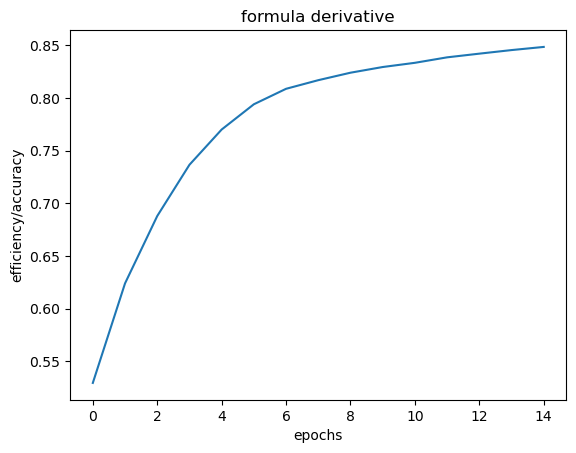

In [7]:
nn.train(X, y, X_test, y_test, 15, 1)
plt.title('formula derivative')
plt.ylabel('efficiency/accuracy')
plt.xlabel('epochs')
plt.plot(nn.epochs, nn.efficiency)
maxima = np.argmax(np.array(nn.efficiency))
print(f'max accuracy is {nn.efficiency[maxima]} at {maxima} epoch' )

max accuracy is 0.8412 at 14 epoch


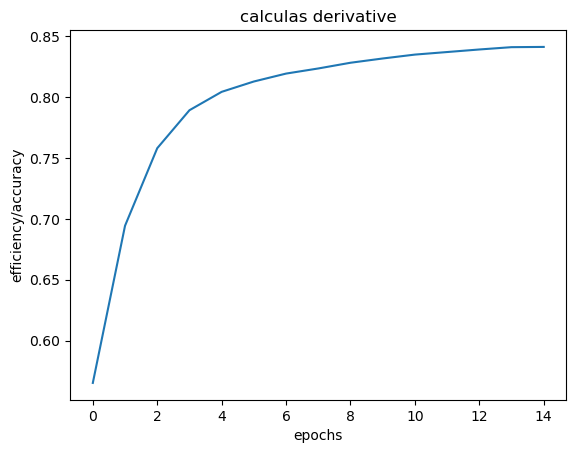

In [8]:
nncd.train(X, y, X_test, y_test, 15, 1)
plt.title('calculas derivative')
plt.ylabel('efficiency/accuracy')
plt.xlabel('epochs')
plt.plot(nncd.epochs, nncd.efficiency)
maxima = np.argmax(np.array(nncd.efficiency))
print(f'max accuracy is {nncd.efficiency[maxima]} at {maxima} epoch' )